In [455]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
#!pip install pmdarima

<br><h1> Sales Predictions <h1>

In [383]:
df=pd.read_csv("train1.csv",sep=';')

In [384]:
display(df.shape)
display(df.head())
display(df.info())
display(df.describe())

(48, 3)

,Date,Sales,Marketing_Expense
0,2011-01-01,100,130
1,2011-02-01,110,133
2,2011-03-01,121,113
3,2011-04-01,109,133
4,2011-05-01,120,151


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Date               48 non-null     object
 1   Sales              48 non-null     int64 
 2   Marketing_Expense  48 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


None

,Sales,Marketing_Expense
count,48.000000,48.000000
mean,183.812500,197.520833
std,59.042594,60.830070
min,99.000000,112.000000
25%,136.750000,145.750000
50%,173.000000,182.500000
75%,221.000000,232.250000
max,320.000000,333.000000


In [385]:
df['Date'] = pd.to_datetime(df['Date'])
df.index=df['Date']
df=df.drop(['Date'],axis=1)

<br><h3> Sales evolution (history) for predictions<h3>

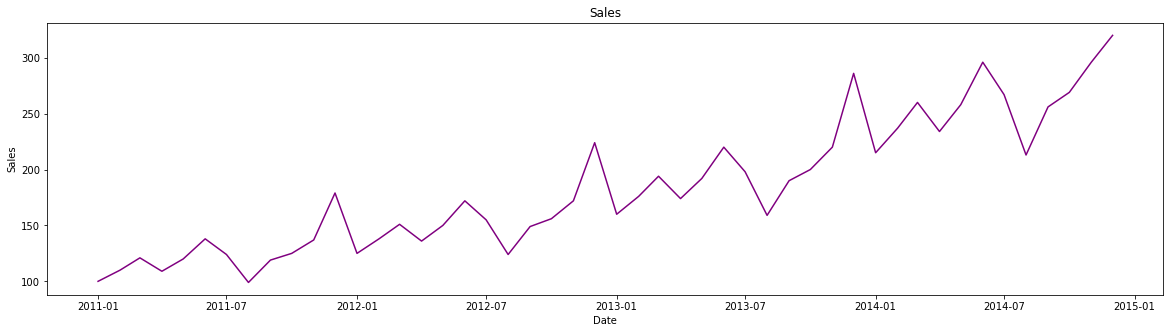

In [386]:

fig, ax = plt.subplots(figsize=(20, 5))


ax.plot(df.index.values,
        df['Sales'],
        color='purple')


ax.set(xlabel="Date",
       ylabel="Sales",
       title="Sales")

plt.show()



<br><h3> create (in history) the target value = the sales prediction for the next month<h3>

In [387]:
steps=-1
df = df.copy()
df['target_sales'] = df['Sales'].shift(steps)
df.head()


,Sales,Marketing_Expense,target_sales
Date,,,
2011-01-01,100,130,110.0
2011-02-01,110,133,121.0
2011-03-01,121,113,109.0
2011-04-01,109,133,120.0
2011-05-01,120,151,138.0


<br><h3> Normalization of the data<h3>

In [389]:
sc = MinMaxScaler(feature_range=(0,1))
sc_in = sc.fit_transform(df[['Sales','Marketing_Expense']])
sc_in = pd.DataFrame(sc_in)
X = sc_in
X.index = df.index


In [390]:
sc_out = sc.fit_transform(df[ ['target_sales']])
y = pd.DataFrame(sc_out)
y.index = df.index


In [391]:
X.rename(columns={0:'Sales', 1:'Marketing_Expense'},inplace=True)
y.rename(columns={0:'target_sales'}, inplace=True)
display(X.head(3))
display(y.head(3))

,Sales,Marketing_Expense
Date,,
2011-01-01,0.004525,0.081448
2011-02-01,0.049774,0.095023
2011-03-01,0.099548,0.004525


,target_sales
Date,
2011-01-01,0.049774
2011-02-01,0.099548
2011-03-01,0.045249


<br><h3> Sets creation <h3>

In [392]:
train_size = int(round(len(df)*0.7,0))
test_size = int(round(len(df)*0.3,0))
train_X = X[:train_size]
train_y = y[: train_size]
test_X = X[train_size:]
test_y = y[train_size:]
print(train_size,test_size)

34 14


In [393]:
display(test_X.head())
display(test_y.head())

,Sales,Marketing_Expense
Date,,
2013-11-01,0.547511,0.796380
2013-12-01,0.846154,0.488688
2014-01-01,0.524887,0.588235
2014-02-01,0.624434,0.710407
2014-03-01,0.728507,0.574661


,target_sales
Date,
2013-11-01,0.846154
2013-12-01,0.524887
2014-01-01,0.624434
2014-02-01,0.728507
2014-03-01,0.610860


In [396]:
season = sm.tsa.seasonal_decompose(X['Sales'],model='add',period = 4)

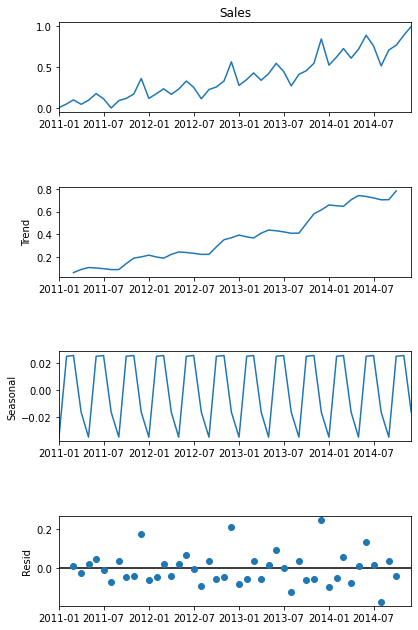

In [397]:
fig = season.plot()
fig.set_figheight(10)



<br><h3>We look for data stationary. We check with Augmented Dickey Fuller test (ADF)<h3>

In [398]:
def test_adf(series,title=''):
    dfout={}
    dftest = sm.tsa.adfuller(series.dropna(), 
                             autolag = 'AIC',
                             regression = 'ct')
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})'] = val
    if dftest[1]<=0.05:
        print("Data is stationary for",title)
    else:
        print("Data is not stationary for", title)

In [399]:
y_test = y['target_sales'][:train_size].dropna()
test_adf(y_test,"target sales")

Data is not stationary for target sales


In [400]:
test_adf(y_test.diff(),"target sales")

Data is stationary for target sales


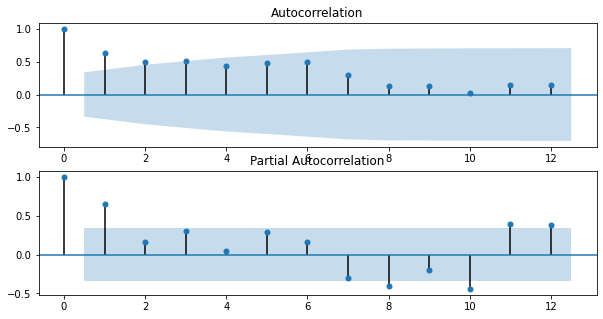

In [401]:
fig,ax = plt.subplots(2,1, figsize=(10,5))
fig = sm.tsa.graphics.plot_acf(y_test, lags=12, ax=ax[0])
fig = sm.tsa.graphics.plot_pacf(y_test, lags=12, ax=ax[1])

In [402]:
step_wise = auto_arima(train_y,
                      train_X,
                      start_p=1,
                      start_q=1,
                      max_p=12,
                      max_q=12,
                      d=1,
                      max_d=12,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-130.749, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-118.606, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-118.611, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-120.266, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-133.520, Time=0.72 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-133.216, Time=0.43 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-131.681, Time=0.58 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-132.768, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-132.573, Time=0.78 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-130.856, Time=0.60 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-135.253, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-132.559, Time=0.60 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-

In [403]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   34
Model:               SARIMAX(2, 1, 1)   Log Likelihood                  73.626
Date:                Sun, 31 Jan 2021   AIC                           -135.253
Time:                        21:19:28   BIC                           -126.273
Sample:                    01-01-2011   HQIC                          -132.231
                         - 10-01-2013                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Sales                 0.0328      0.058      0.565      0.572      -0.081       0.146
Marketing_Expense     1.0216      0.061     16.622      0.000       0.901       1.142
ar.L1                -0.2143      0.212     -1.012      0.312      -0.629       0.201
ar.L2                -0.5283      0.254     -2.080      0.038      -1.026      -0.030
ma.L1                -0.6221      0.265     -2.344      0.019      -1.142      -0.102
sigma2                0.0006      0.000      3.388      0.001       0.000       0.001
===================================================================================
Ljung-Box (Q):                       20.55   Jarque-Bera (JB):                 0.71
Prob(Q):                              0.94   Prob(JB):                         0.70
Heteroskedasticity (H):               1.81   Skew:                            -0.35
Prob(H) (two-sided):                  0.34   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<br><h3>Training the model SARIMAX with the p,d,q values estimate<h3>

In [404]:

model = SARIMAX(train_y,
               exog=train_X,
               order=(2,1,1)
              )


C:\Users\LaurentPourchot\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\LaurentPourchot\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [405]:
results = model.fit()

In [406]:
predictions = results.predict(start = train_size,
                             end = train_size + test_size-1,
                             exog = test_X)

In [407]:
act = pd.DataFrame(y.iloc[train_size:,0])
act.head()

,target_sales
Date,
2013-11-01,0.846154
2013-12-01,0.524887
2014-01-01,0.624434
2014-02-01,0.728507
2014-03-01,0.610860


In [408]:
predictions = pd.DataFrame(predictions)
predictions.index=test_X.index
predictions['target']= act['target_sales']
predictions.rename(columns={0:'predictions'},inplace=True)
predictions.head()

,predictions,target
Date,,
2013-11-01,0.828799,0.846154
2013-12-01,0.502491,0.524887
2014-01-01,0.612470,0.624434
2014-02-01,0.748011,0.728507
2014-03-01,0.601201,0.610860


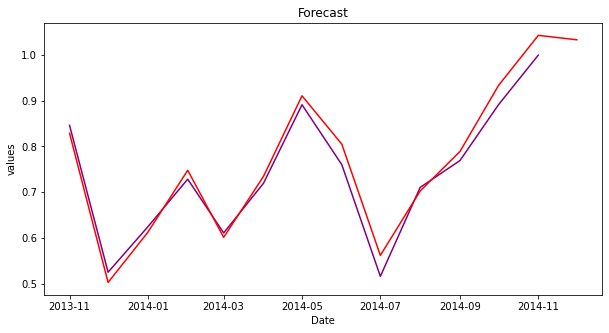

In [413]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(predictions.index.values,
        predictions['target'],
        color='purple')
ax.plot(predictions.index.values,
        predictions['predictions'],
        color='red')        
    
ax.set(xlabel="Date",
       ylabel="values",
       title="Forecast")
plt.show()

<br><h2> Model Evaluation<h2>

In [450]:
pred_target = np.array(predictions['target'].values)
pred_pred = np.array(predictions['predictions'].values)
mse = mean_squared_error(pred_pred[:13],pred_target[:13])
print(mse)


0.0007880782641841807


In [460]:
"""
We can scale back the prediction and target
"""

data_predictions =pd.DataFrame(sc.inverse_transform(predictions[['predictions']]))
data_target = pd.DataFrame(sc.inverse_transform(predictions[['target']]))